# Generative Adversarial Networks: (GANs)

---

## A implicit generative model
where the probability distribution is implicitly represented by a model of its sampling process. The most prominent example is generative adversarial networks (GANs), where new samples from the data distribution are synthesized by transforming a random Gaussian vector with a neural network.

---

GANs were originally proposed by Ian Goodfellow et al. in a seminal paper called [Generative Adversarial Nets](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf).


GANs are a `framework` where 2 models (usually `neural networks`), called `generator (G)` and `discriminator (D)`, play a `minimax game` against each other. The generator is trying to learn the `distribution of real data` and is the network which we're usually interested in. During the game the goal of the generator is to trick the discriminator into "thinking" that the images it generates is real. The goal of the discriminator, on the other hand, is to correctly discriminate between the generated (fake) images and real images coming from some dataset (e.g. MNIST).

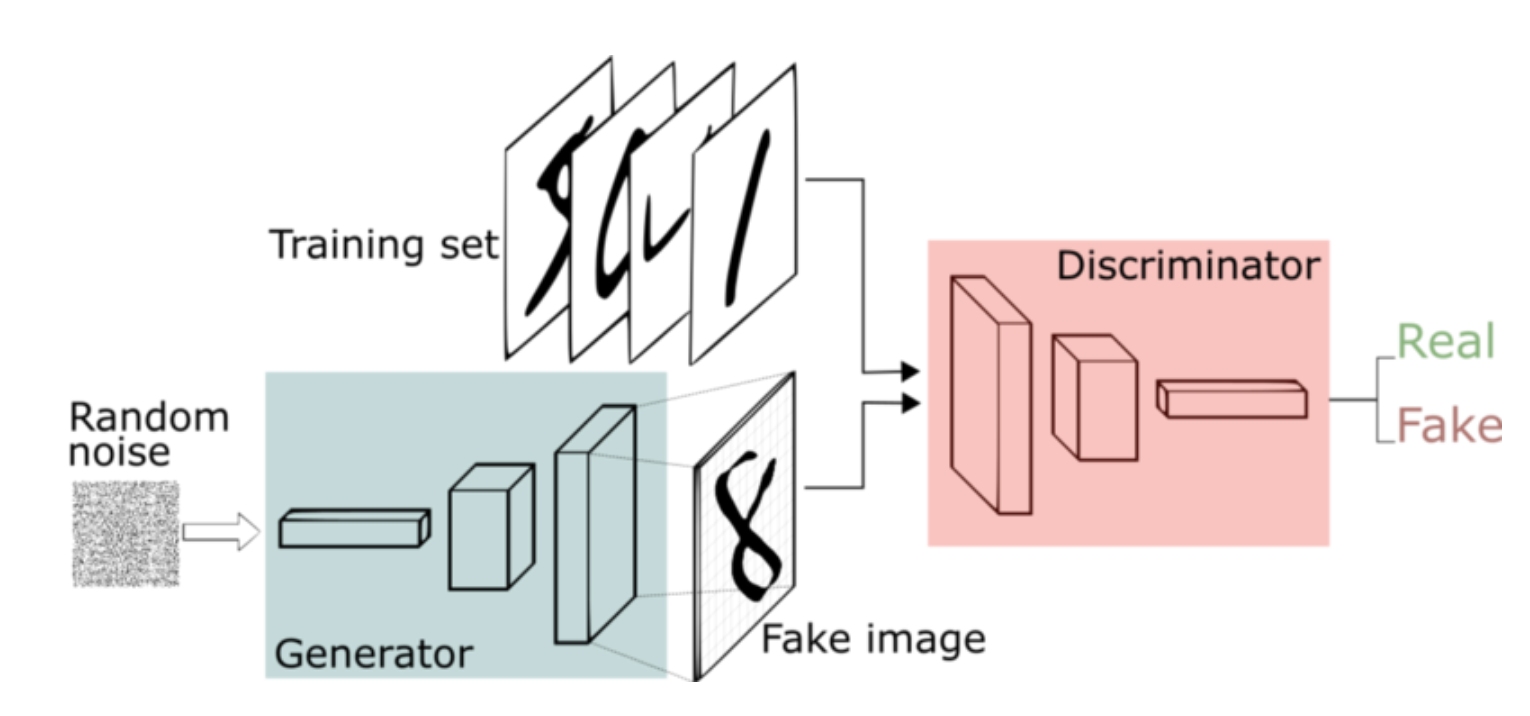




At the equilibrium (Nash) of the two player zero sum game the generator learns to generate images indistinguishable from the real images and the best that discriminator can do is output 0.5 - meaning it's 50% sure that what you gave him is a real image (and 50% sure that it's fake) - i.e. it doesn't have a clue of what's happening!

### Potentially confusing parts: <br/><br/>
`minimax game` - basically they have some goal (objective function) and one is trying to minimize it, the other to maximize it.  <br/><br/>
`distribution of real data` - basically you can think of any data you use as a point in the `n-dimensional` space. For example, MNIST 28x28 image when flattened has 784 numbers. So 1 image is simply a point in the 784-dimensional space. That's it. when I say `n` in order to visualize it just think of `3` or `2` dimensions - that's how everybody does it. So you can think of your data as a 3D/2D cloud of points. Each point has some probability associated with it - how likely is it to appear - that's the `distribution` part. So if your model has internal representation of this 3D/2D point cloud there is nothing stopping it from generating more points from that cloud! And those are new images (be it human faces, digits or whatever) that never existed!

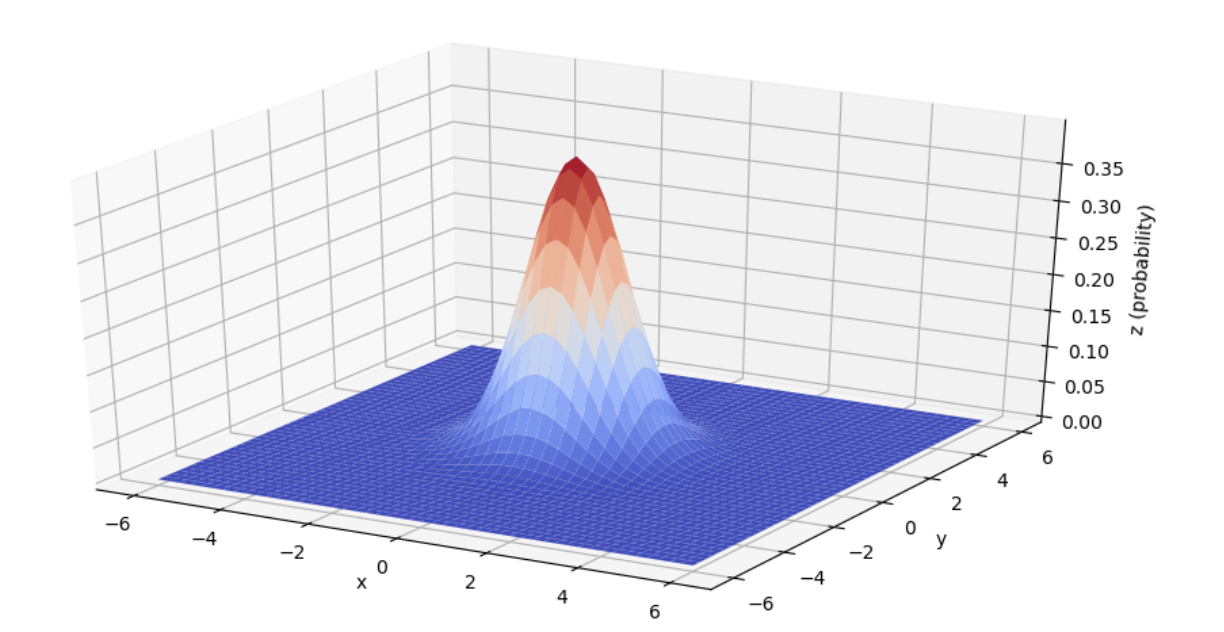

Here is an example of a simple data distribution. The data here is 2-dimensional and the height of the plot is the probability of certain datapoint appearing. You can see that points around (0, 0) have the highest probability of happening. Those datapoints could be your 784-dimensional images projected into 2-dimensional space via PCA, t-SNE, UMAP, etc. (you don't need to know what these are, they are just some dimensionality reduction methods out there).

In reality this plot would have multiple peaks (`multi-modal`) and wouldn't be this nice.

In [ ]:
import os
import re
import enum
from tqdm import tqdm


import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt


import torch
from torch import nn
from torch.optim import Adam
from torchvision import transforms, datasets
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader

In [ ]:
DATA_DIR_PATH = os.path.join(os.getcwd(), 'data')  # all data both input (MNIST) and generated will be stored here
DEBUG_IMAGERY_PATH = os.path.join(DATA_DIR_PATH, 'debug_imagery')  # we'll be dumping images here during GAN training

os.makedirs(DATA_DIR_PATH, exist_ok=True)
os.makedirs(DEBUG_IMAGERY_PATH, exist_ok=True)

## Understand the data!

You should always invest time to understand your data. You should be able to answer questions like:
1. How many images do I have?
2. What's the shape of my image?
3. How do my images look like?



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 14279756.60it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 486143.16it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1008369.39it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5175367.77it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Dataset size: 60000 images.
Image shape torch.Size([1, 28, 28])


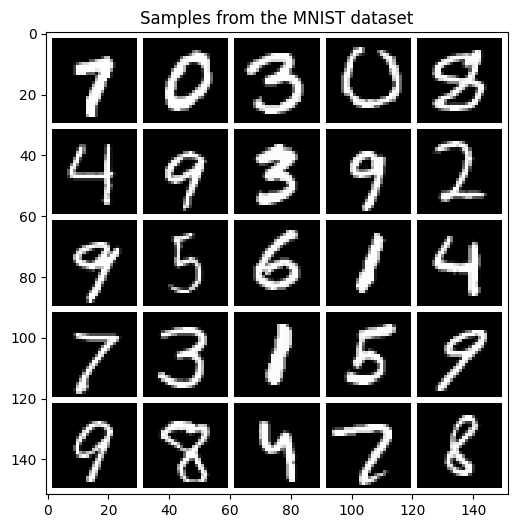

In [ ]:
batch_size = 128
MNIST_IMG_SIZE = 28  # MNIST images have 28x28 resolution, it's just convinient to put this into a constant you'll see later why

# Images are usually in the [0., 1.] or [0, 255] range, Normalize transform will bring them into [-1, 1] range
# It's one of those things somebody figured out experimentally that it works (without special theoretical arguments)
# https://github.com/soumith/ganhacks <- you can find more of those hacks here
'''
<<transforms.ToTensor()>>

Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]

<<transforms.Normalize((.5,), (.5,))>>

Normalize does the following for each channel: image = (image - mean) / std
The parameters mean, std are passed as 0.5, 0.5 in our case.
This will normalize the image in the range [-1,1]. For example, the minimum value 0 will be converted to (0-0.5)/0.5=-1,
the maximum value of 1 will be converted to (1-0.5)/0.5=1.

'''

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((.5,), (.5,))
    ])


# MNIST is a super simple, "hello world" dataset so it's included in PyTorch.
# First time you run this it will download the MNIST dataset and store it in DATA_DIR_PATH
# the 'transform' (defined above) will be applied to every single image
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Nice wrapper class helps us load images in batches (suitable for GPUs)
mnist_data_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Let's answer our questions

# Q1: How many images do I have?
print(f'Dataset size: {len(mnist_dataset)} images.')

num_imgs_to_visualize = 25  # number of images we'll display
batch = next(iter(mnist_data_loader))  # take a single batch from the dataset
img_batch = batch[0]  # extract only images and ignore the labels (batch[1])
img_batch_subset = img_batch[:num_imgs_to_visualize]  # extract only a subset of images

# Q2: What's the shape of my image?
# format is (B,C,H,W), B - number of images in batch, C - number of channels, H - height, W - width
print(f'Image shape {img_batch_subset.shape[1:]}')  # we ignore shape[0] - number of imgs in batch.

# Q3: How do my images look like?
# Creates a 5x5 grid of images, normalize will bring images from [-1, 1] range back into [0, 1] for display
# pad_value is 1. (white) because it's 0. (black) by default but since our background is also black,
# we wouldn't see the grid pattern so I set it to 1.
grid = make_grid(img_batch_subset, nrow=int(np.sqrt(num_imgs_to_visualize)), normalize=True, pad_value=1.)
grid = np.moveaxis(grid.numpy(), 0, 2)  # from CHW -> HWC format that's what matplotlib expects! Get used to this.
plt.figure(figsize=(6, 6))
plt.title("Samples from the MNIST dataset")
plt.imshow(grid)
plt.show()

## Understand the model (neural networks)!

Let's define the generator and discriminator networks!

The original paper used the maxout activation and dropout for regularization <br/>
We are using `LeakyReLU` instead and `batch normalization` which came after the original paper was published.

Those design decisions are inspired by the DCGAN model which came later than the original GAN.

In [ ]:
# Size of the generator's input vector. Generator will eventually learn how to map these into meaningful images!
LATENT_SPACE_DIM = 100

'''
<<torch.randn>>
Returns a tensor filled with random numbers from a normal distribution with mean 0 and variance 1 (also called the standard normal distribution).
'''

# This one will produce a batch of those vectors
def get_gaussian_latent_batch(batch_size, device):
    return torch.randn((batch_size, LATENT_SPACE_DIM), device=device)


def vanilla_block(in_feat, out_feat, normalize=True, activation=None):
    layers = [nn.Linear(in_feat, out_feat)]
    if normalize:
        layers.append(nn.BatchNorm1d(out_feat))
    layers.append(nn.LeakyReLU(0.2) if activation is None else activation)
    return layers


class GeneratorNet(torch.nn.Module):
    """Simple 4-layer MLP generative neural network.
    """

    def __init__(self, img_shape=(MNIST_IMG_SIZE, MNIST_IMG_SIZE)):
        super().__init__()
        self.generated_img_shape = img_shape
        num_neurons_per_layer = [LATENT_SPACE_DIM, 256, 512, 1024, img_shape[0] * img_shape[1]]

        # These are pretty much just linear layers followed by LeakyReLU and batch normalization
        # Except for the last layer where we exclude batch normalization and we add Tanh (maps images into our [-1, 1] range!)
        self.net = nn.Sequential(
            *vanilla_block(num_neurons_per_layer[0], num_neurons_per_layer[1]),
            *vanilla_block(num_neurons_per_layer[1], num_neurons_per_layer[2]),
            *vanilla_block(num_neurons_per_layer[2], num_neurons_per_layer[3]),
            *vanilla_block(num_neurons_per_layer[3], num_neurons_per_layer[4], normalize=False, activation=nn.Tanh())
        )

    def forward(self, latent_vector_batch):
        img_batch_flattened = self.net(latent_vector_batch)
        # just un-flatten using view into (N, 1, 28, 28) shape for MNIST
        return img_batch_flattened.view(img_batch_flattened.shape[0], 1, *self.generated_img_shape)

# You can interpret the output from the discriminator as a probability and the question it should
# give an answer to is "hey is this image real?". If it outputs 1. it's 100% sure it's real. 0.5 - 50% sure, etc.
class DiscriminatorNet(torch.nn.Module):
    """Simple 3-layer MLP discriminative neural network. It should output probability 1. for real images and 0. for fakes.
    """

    def __init__(self, img_shape=(MNIST_IMG_SIZE, MNIST_IMG_SIZE)):
        super().__init__()
        num_neurons_per_layer = [img_shape[0] * img_shape[1], 512, 256, 1]

        # Last layer is Sigmoid function - basically the goal of the discriminator is to output 1.
        # for real images and 0. for fake images and sigmoid is clamped between 0 and 1 so it's perfect.
        self.net = nn.Sequential(
            *vanilla_block(num_neurons_per_layer[0], num_neurons_per_layer[1], normalize=False),
            *vanilla_block(num_neurons_per_layer[1], num_neurons_per_layer[2], normalize=False),
            *vanilla_block(num_neurons_per_layer[2], num_neurons_per_layer[3], normalize=False, activation=nn.Sigmoid())
        )

    def forward(self, img_batch):
        img_batch_flattened = img_batch.view(img_batch.shape[0], -1)  # flatten from (N,1,H,W) into (N, HxW)
        return self.net(img_batch_flattened)

## GAN Training


So far we got familiar with data and our models. <br/>
Now, How to actually train your GAN?

Let's start with understanding the loss function! We'll be using `BCE (binary cross-entropy loss`), let's see why? <br/>

If we input real images into the discriminator we expect it to output 1 (I'm 100% sure that this is a real image). <br/>
The further away it is from 1 and the closer it is to 0 the more we should penalize it, as it is making wrong prediction. <br/>
So this is how the loss should look like in that case (it's basically `-log(x)`):

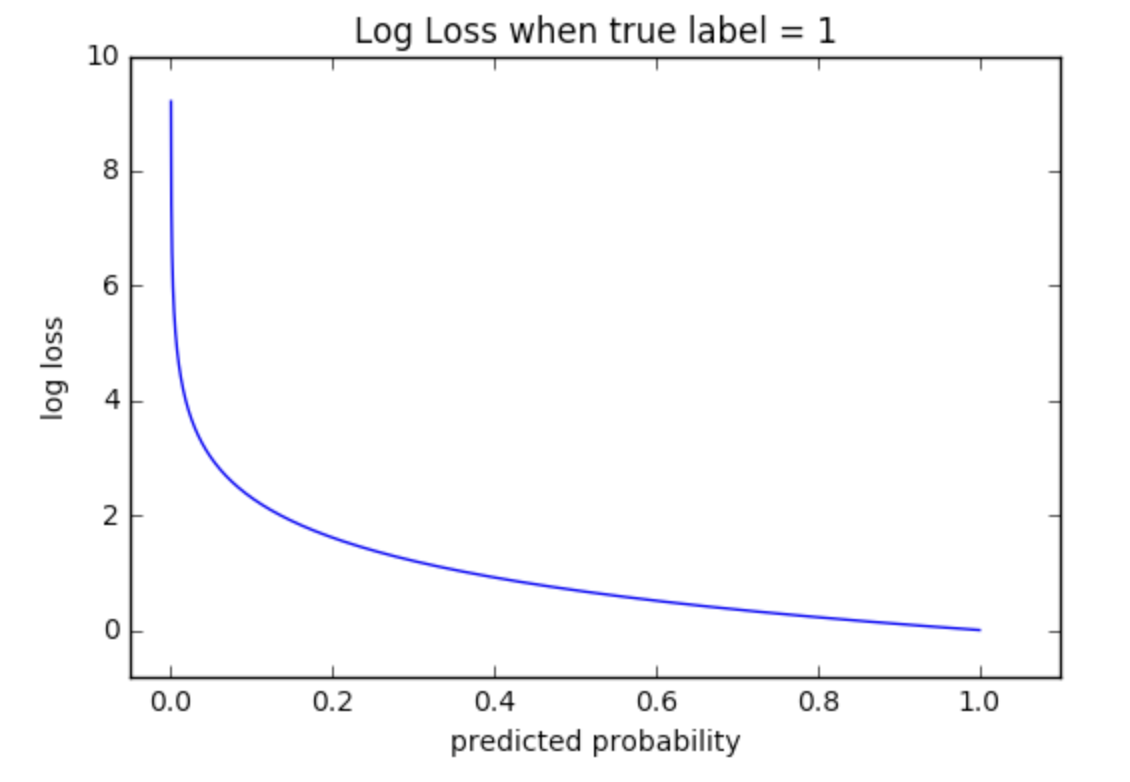

BCE loss basically becomes `-log(x)` when it's target (true) label is 1. <br/>

Similarly for fake images, the target (true) label is 0 (as we want the discriminator to output 0 for fake images) and we want to penalize the generator if it starts outputing values close to 1. So we basically want to mirror the above loss function and that's just: `-log(1-x)`. <br/>

BCE loss basically becomes `-log(1-x)` when it's target (true) label is 0.<br/>

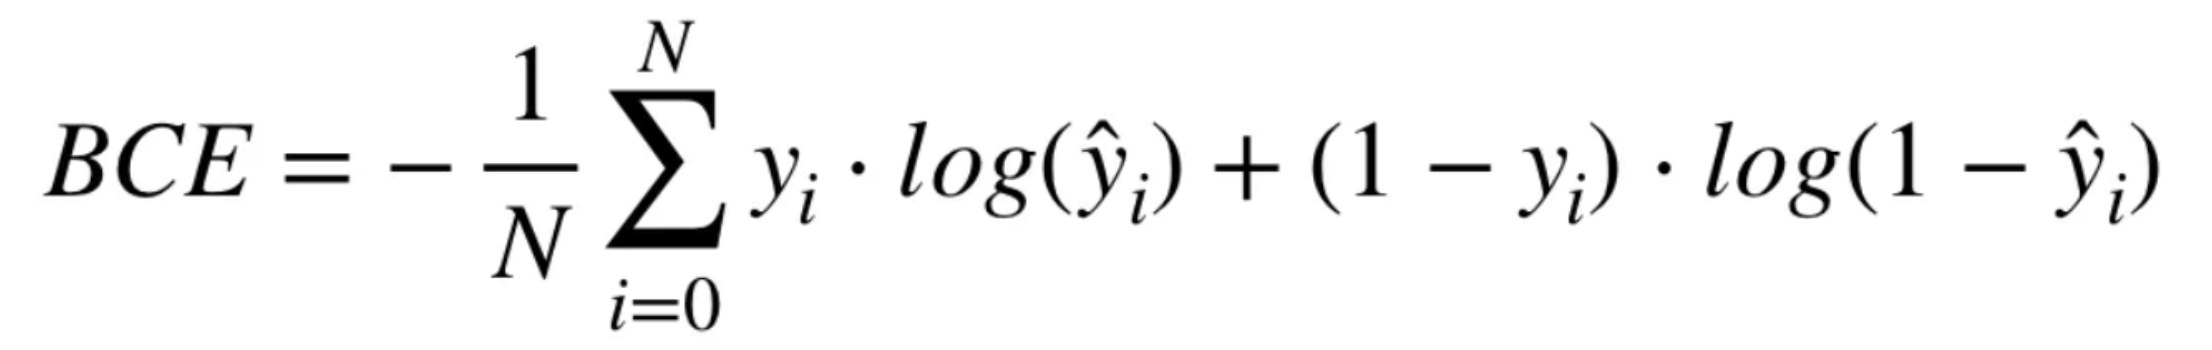

## GAN Training Algorithm

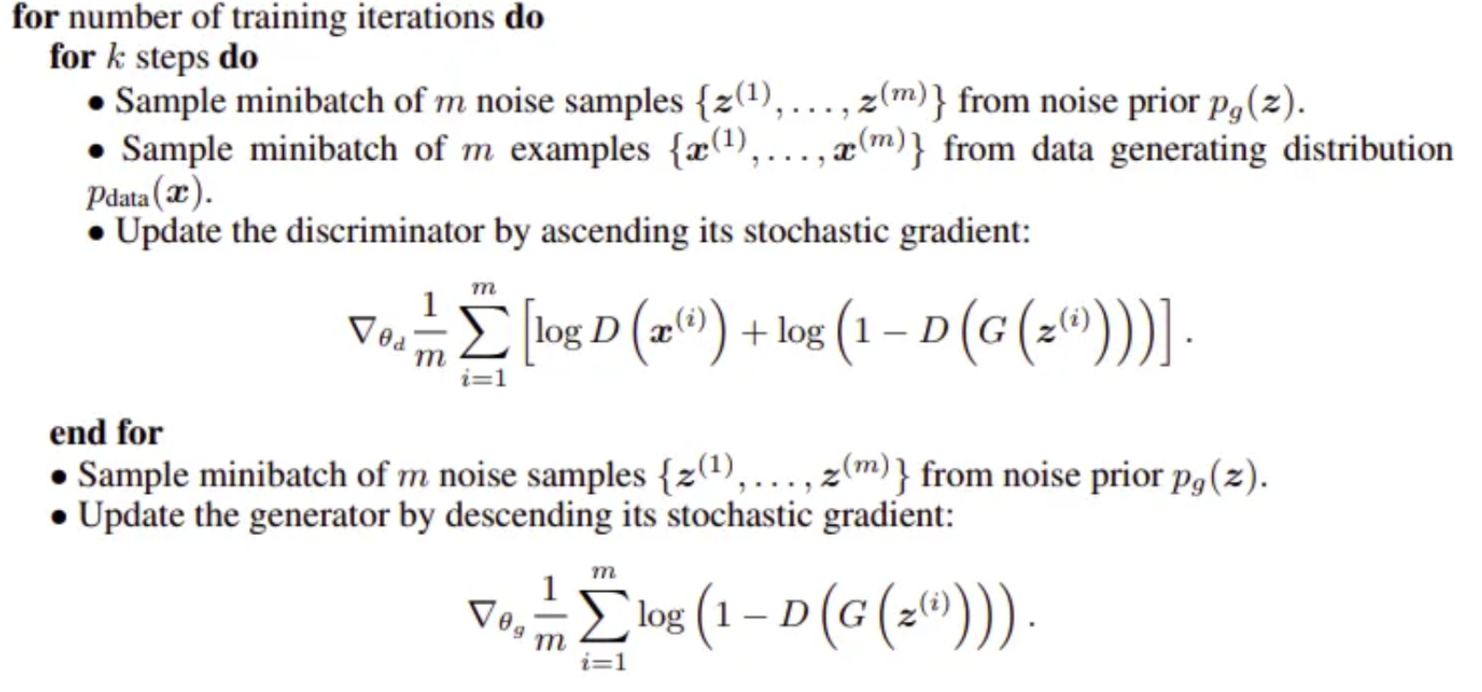

### Training utility functions
Let's define some useful utility functions:

In [ ]:
# Tried SGD for the discriminator, had problems tweaking it - Adam simply works nicely but default lr 1e-3 won't work!
def get_optimizers(d_net, g_net):
    d_opt = Adam(d_net.parameters(), lr=0.0002, betas=(0.5, 0.999))
    g_opt = Adam(g_net.parameters(), lr=0.0002, betas=(0.5, 0.999))
    return d_opt, g_opt

In [ ]:
# Hopefully you have some GPU ^^
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

####################### constants #####################
# For logging purpose
ref_batch_size = 16
ref_noise_batch = get_gaussian_latent_batch(ref_batch_size, device)  # Track G's quality during training on fixed noise vectors

discriminator_loss_values = []
generator_loss_values = []

img_cnt = 0

# For training purpose
num_epochs = 20  # feel free to increase this
debug_imagery_log_freq = 50
checkpoint_freq = 2

########################################################

# Prepare feed-forward nets (place them on GPU if present) and optimizers which will tweak their weights
discriminator_net = DiscriminatorNet().train().to(device)
generator_net = GeneratorNet().train().to(device)

discriminator_opt, generator_opt = get_optimizers(discriminator_net, generator_net)

# 1s (real_images_gt) will configure BCELoss into -log(x) (check out the loss image above that's -log(x))
# whereas 0s (fake_images_gt) will configure it to -log(1-x)
# So that means we can effectively use binary cross-entropy loss to achieve adversarial loss!
adversarial_loss = nn.BCELoss()
real_images_gt = torch.ones((batch_size, 1), device=device)
fake_images_gt = torch.zeros((batch_size, 1), device=device)


# GAN training loop, it's always smart to first train the discriminator so as to avoid mode collapse!
# A mode collapse, for example, is when your generator learns to only generate a single digit instead of all 10 digits!
for epoch in tqdm(range(num_epochs)):
    for batch_idx, (real_images, _) in enumerate(mnist_data_loader):

        real_images = real_images.to(device)  # Place imagery on GPU (if present)

        #
        # Train discriminator: maximize V = log(D(x)) + log(1-D(G(z))) or equivalently minimize -V
        # Note: D = discriminator, x = real images, G = generator, z = latent Gaussian vectors, G(z) = fake images
        #

        # Zero out .grad variables in discriminator network,
        # otherwise we would have corrupt results - leftover gradients from the previous training iteration
        discriminator_opt.zero_grad()

        # -log(D(x)) <- we minimize this by making D(x)/discriminator_net(real_images) as close to 1 as possible
        real_discriminator_loss = adversarial_loss(discriminator_net(real_images), real_images_gt)

        # G(z) | G == generator_net and z == get_gaussian_latent_batch(batch_size, device)
        fake_images = generator_net(get_gaussian_latent_batch(batch_size, device))
        # D(G(z)), we call detach() so that we don't calculate gradients for the generator during backward()
        fake_images_predictions = discriminator_net(fake_images.detach())
        # -log(1 - D(G(z))) <- we minimize this by making D(G(z)) as close to 0 as possible
        fake_discriminator_loss = adversarial_loss(fake_images_predictions, fake_images_gt)

        discriminator_loss = real_discriminator_loss + fake_discriminator_loss
        discriminator_loss.backward()  # this will populate .grad vars in the discriminator net
        discriminator_opt.step()  # perform D weights update according to optimizer's strategy

        #
        # Train generator: minimize V1 = log(1-D(G(z))) or equivalently maximize V2 = log(D(G(z))) (or min of -V2)
        # The original expression (V1) had problems with diminishing gradients for G when D is too good.
        #

        # if you want to cause mode collapse probably the easiest way to do that would be to add "for i in range(n)"
        # here (simply train G more frequent than D), n = 10 worked for me other values will also work - experiment.

        # Zero out .grad variables in generator network (otherwise we would have corrupt results)
        generator_opt.zero_grad()

        # D(G(z)) (see above for explanations)
        generated_images_predictions = discriminator_net(generator_net(get_gaussian_latent_batch(batch_size, device)))
        # By placing real_images_gt here we minimize -log(D(G(z))) which happens when D approaches 1
        # i.e. we're tricking D into thinking that these generated images are real!
        generator_loss = adversarial_loss(generated_images_predictions, real_images_gt)

        generator_loss.backward()  # this will populate .grad vars in the G net (also in D but we won't use those)
        generator_opt.step()  # perform G weights update according to optimizer's strategy

        #
        # Logging and checkpoint creation
        #

        generator_loss_values.append(generator_loss.item())
        discriminator_loss_values.append(discriminator_loss.item())


        # Save intermediate generator images
        if batch_idx % debug_imagery_log_freq == 0:
            with torch.no_grad():
                generator_net.eval()
                log_generated_images = generator_net(ref_noise_batch)
                log_generated_images_resized = nn.Upsample(scale_factor=2.5, mode='nearest')(log_generated_images)
                out_path = os.path.join(DEBUG_IMAGERY_PATH, f'{str(img_cnt).zfill(6)}.jpg')
                save_image(log_generated_images_resized, out_path, nrow=int(np.sqrt(ref_batch_size)), normalize=True)
                img_cnt += 1


# Save the latest generator in the binaries directory
torch.save(generator_net.state_dict(), 'latest_gan_generator.pth')

100%|██████████| 20/20 [04:47<00:00, 14.38s/it]


## Generate images with your vanilla GAN

Now, we can use the generator we trained to generate some MNIST-like imagery!

Let's define a couple of utility functions which will make things cleaner!

In [ ]:
# fig, ax = plt.subplots(2, figsize=(7, 7))

# ax[0].plot(np.array(generator_loss_values))
# ax[0].set_xlabel('iterations')
# ax[0].set_ylabel('Genentor loss value')
# ax[0].set_title('Training Generator loss')

# ax[1].plot(np.array(discriminator_loss_values))
# ax[1].set_xlabel('iterations')
# ax[1].set_ylabel('Discriminator loss value')
# ax[1].set_title('Training Discriminator loss')

# fig.tight_layout()
# plt.show()

def postprocess_generated_img(generated_img_tensor):
    assert isinstance(generated_img_tensor, torch.Tensor), f'Expected PyTorch tensor but got {type(generated_img_tensor)}.'

    # Move the tensor from GPU to CPU, convert to numpy array, extract 0th batch, move the image channel
    # from 0th to 2nd position (CHW -> HWC)
    generated_img = np.moveaxis(generated_img_tensor.to('cpu').numpy()[0], 0, 2)

    # # Since MNIST images are grayscale (1-channel only) repeat 3 times to get RGB image
    # generated_img = np.repeat(generated_img,  3, axis=2)

    # Imagery is in the range [-1, 1] (generator has tanh as the output activation) move it into [0, 1] range
    generated_img -= np.min(generated_img)
    generated_img /= np.max(generated_img) # np.min(generated_img) is now 0. so, its similar to (x - x_min) / (x_max - x_min)

    return generated_img


# This function will generate a random vector pass it to the generator which will generate a new image
# which we will just post-process and return it
def generate_from_random_latent_vector(generator):
    with torch.no_grad():  # Tells PyTorch not to compute gradients which would have huge memory footprint

        # Generate a single random (latent) vector
        latent_vector = get_gaussian_latent_batch(1, next(generator.parameters()).device)

        # Post process generator output (as it's in the [-1, 1] range, remember?)
        generated_img = postprocess_generated_img(generator(latent_vector))

    return generated_img

### We're now ready to generate some new digit images!

Generating new MNIST-like images!


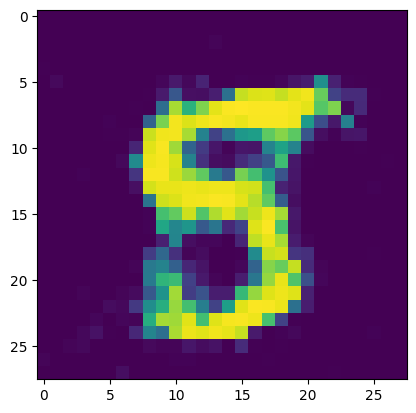

In [ ]:
# Hopefully you have some GPU ^^
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# let's load the model, this is a dictionary containing model weights but also some metadata
# state_dict - contains the actuall neural network weights
model_path = '/content/latest_gan_generator.pth'
model_state = torch.load(model_path)

# Let's instantiate a generator net and place it on GPU (if you have one)
generator = GeneratorNet().to(device)
# Load the weights, strict=True just makes sure that the architecture corresponds to the weights 100%
generator.load_state_dict(model_state, strict=True)
generator.eval()  # puts some layers like batch norm in a good state so it's ready for inference

print('Generating new MNIST-like images!')
generated_img = generate_from_random_latent_vector(generator)
if generated_img.dtype != np.uint8:
        generated_img = (generated_img*255).astype(np.uint8)
plt.imshow(generated_img)
plt.show()